## GEO 450k and EPIC Data Downloads

In [1]:
from collections import Counter
from ftplib import FTP
import gzip
import io
import math
import os 
import pickle
import random
import shutil
import subprocess
from typing import Dict, List, Union

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from GEODataProcessing.SeriesMatrixMetaExtractor import SeriesMatrixMetaExtractor

In [2]:
home_dir = os.getcwd() + '/'

In [3]:
wd = '/u/nobackup/mcdbscratch/colinpat/EPMTraitAssociation/'

In [4]:
four_50k_meta = f'{home_dir}450k_top_500.txt'
epic_meta = f'{home_dir}epic_top_500.txt'

In [5]:
def parse_meta_data(file_path, platform_id):
    with open(file_path, 'r') as meta:
        all_exps = {}
        exp_info = {}
        for line in meta:
            line_strip = line.strip()
            if not line_strip:
                if exp_info:
                    all_exps[exp_info['accession_id']] = exp_info
                exp_info = {}
            else:
                if not exp_info:
                    exp_info['title'] = ' '.join(line_strip.split(' ')[1:])
                elif '(Submitter supplied)' in line_strip:
                    exp_info['description'] = line_strip.replace('(Submitter supplied) ', '')
                elif 'Organism' in line_strip:
                    exp_info['organism'] = line_strip.split(':')[1].strip()
                elif 'Platform' in line_strip:
                    line_split = line_strip.split(' ')
                    exp_info['platform_id'] = platform_id
                    exp_info['sample_number'] = int(line_split[-2])
                elif 'FTP' in line_strip:
                    exp_info['ftp_link'] = line_strip.split(' ')[-1]
                elif 'Series' in line_strip:
                    line_split = line_strip.split('\t')
                    exp_info['accession_id'] = line_strip.split(': ')[1].split('\t')[0]
    return all_exps

## Parse File Metadata 

In [6]:
all_exp = parse_meta_data(four_50k_meta, 'GPL13534')

In [7]:
all_exp.update(parse_meta_data(epic_meta, 'GPL21145'))

## FTP Walking Functions

In [8]:
def retrieve_exp_info(exp):
    file_links = {}
    raw_url = exp['ftp_link']
    processed_link = raw_url.replace('ftp://', '').split('/')[0]
    exp_dir = '/'.join(raw_url.replace('ftp://', '').split('/')[1:])
    ftp = FTP(processed_link)
    ftp.login()
    ftp.cwd(exp_dir)
    directories = ftp.nlst()
    for direct in directories:
        ftp.cwd(direct)
        files = ftp.nlst()
        file_links[direct] = (ftp.pwd(), files)
        ftp.cwd('..')
    if 'suppl' in file_links:
        if 'filelist.txt' in file_links['suppl'][1]:
            ftp.cwd('suppl')
            supp_lines = []
            ftp.retrlines('RETR filelist.txt', supp_lines.append)
            file_links['supplemental_files'] = supp_lines
    ftp.close()
    return exp['accession_id'], f'ftp://{processed_link}', file_links

In [9]:
if not os.path.exists('idat_exp_meta.pkl'):
    processed_links = joblib.Parallel(n_jobs=8, verbose=10)(joblib.delayed(retrieve_exp_info)(exp) for exp in all_exp.values())
    for exp_id, ftp_head, links in processed_links:
        all_exp[exp_id].update(links)
        all_exp[exp_id]['ftp_head'] = ftp_head
        
    idat_exps = []
    idat_sample_count = 0

    for exp_id, exp in all_exp.items():
        supp_files = exp.get('supplemental_files', [])
        for file in supp_files:
            if 'IDAT' in file.upper():
                idat_exps.append(exp_id)
                idat_sample_count += exp['sample_number']
                break
                
    idat_exp_info = {key: value for key, value in all_exp.items() if key in idat_exps}
    
    with open('idat_exp_meta.pkl', 'wb') as out:
        pickle.dump(idat_exp_info, out)
        
else:
    with open('idat_exp_meta.pkl', 'rb') as info:
        idat_exp_info = pickle.load(info)
        idat_exps = []

### Dowload series matrix files for files with IDAT files available

In [10]:
series_output_dir = f'{wd}series_matrices/'

In [11]:
def download_series_matrix(exp, output_directory):
    matrix_head, files = exp.get('matrix', (None, None))
    if not matrix_head:
        return exp['accession_id']
    else:
        series_head = f'{exp["ftp_head"]}/{matrix_head}/'
        series_file = None
        if len(files) == 1:
            series_file = files[0]
        else:
            for file in files:
                if exp['platform_id'].upper() in file.upper():
                    series_file = file
        if not series_file:
            return exp['accession_id']
        if os.path.exists(f'{output_directory}{series_file}'):
            return 0
        wget_command = ['wget', '-nd', '-P', 
                        output_directory, f'{series_head}{series_file}']
        p = subprocess.Popen(args=wget_command)
        p.wait()
        if p.returncode:
            return exp['accession_id']
        else:
            return 0

In [12]:
download_status = joblib.Parallel(n_jobs=32, verbose=10)(joblib.delayed(download_series_matrix)
                                                         (*[all_exp[exp], series_output_dir]) for exp in idat_exps)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   0 out of   0 | elapsed:    0.0s finished


## Parse Series Matrices to Extract MetaData 

In [13]:
def extract_meta(exp, series_directory):
    matrix_head, files = exp.get('matrix', (None, None))
    series_file = None
    if len(files) == 1:
        series_file = files[0]
    else:
        for file in files:
            if exp['platform_id'].upper() in file.upper():
                series_file = file
    directory = series_directory if series_directory.endswith('/') else f'{series_directory}/'
    series_path = f'{directory}{series_file}'
    matrix_parser = SeriesMatrixMetaExtractor(series_matrix_path=series_path, sample_id='!Sample_geo_accession', phenotype_ids=['!Sample_characteristics_ch1'])
    matrix_parser.get_meta_data()
    return matrix_parser.phenotype_matrix 

In [14]:
if not os.path.exists(f'{wd}all_meta.pkl'):
    exp_sample_meta = joblib.Parallel(n_jobs=8, verbose=10)(joblib.delayed(extract_meta)(*[exp, series_output_dir]) for exp in idat_exp_info.values())
    all_meta = {}
    for exp in exp_sample_meta:
        all_meta.update(exp)
    with open(f'{wd}all_meta.pkl', 'wb') as out:
        pickle.dump(all_meta, out)
else:
    with open(f'{wd}all_meta.pkl', 'rb') as meta:
        all_meta = pickle.load(meta)

### Update Meta with File Info

In [15]:
def get_sample_idat_meta(gsm_id, gsm_info, supp_files):
    idat_files = {}
    for file in supp_files:
        if gsm_id in file:
            file_name, file_date = file.strip().split('\t')[1:3] 
            if 'grn' in file_name.lower():
                idat_files['Grn'] = file_name
            elif 'red' in file_name.lower():
                idat_files['Red'] = file_name
            idat_files['idat_date'] = file_date
            if len(idat_files) == 3:
                break
    return gsm_id, idat_files

In [16]:
if not os.path.exists(f'{wd}idat_meta.pkl'):
    sample_idat_links = joblib.Parallel(n_jobs=8, verbose=10)(joblib.delayed(get_sample_idat_meta)
                                                              (*[gsm_id, gsm_info, idat_exp_info[gsm_info['experiment_id']]['supplemental_files']]) for gsm_id, gsm_info in all_meta.items())
    idat_sample_meta = {}
    for gsm_id, idat_links in sample_idat_links:
        if len(idat_links) == 3:
            sample_info = all_meta[gsm_id]
            sample_info.update(idat_links)
            idat_sample_meta[gsm_id] = sample_info
    with open(f'{wd}idat_meta.pkl', 'wb') as out:
        pickle.dump(idat_sample_meta, out)
else:
    with open(f'{wd}idat_meta.pkl', 'rb') as meta:
        idat_sample_meta = pickle.load(meta)

### Explore Phenotype Data 

In [17]:
def search_for_age(gsm_meta: dict) -> bool:
    for key in gsm_meta:
        if 'age' in key.lower() and 'stage' not in key.lower():
            return True
    return False

In [18]:
idat_age_meta = {key:value for key, value in idat_sample_meta.items() if search_for_age(value)}

In [19]:
idat_age_exps = set(gsm_meta['experiment_id'] for gsm_meta in idat_age_meta.values())
idat_exps = {key:value for key, value in idat_exp_info.items() if key in idat_age_exps}

In [20]:
# manually remove cancer related exps
exps_to_drop = ['GSE131482', 'GSE68825', 'GSE60274', 'GSE104293', 'GSE92462', 'GSE69636', 'GSE69633', 'GSE96879',
                'GSE132804', 'GSE72308', 'GSE157341', 'GSE101764', 'GSE72021', 'GSE108462', 'GSE72251', 'GSE72245', 
                'GSE88883', 'GSE111933', 'GSE133918',  'GSE132804', 'GSE72308', 'GSE157341', 'GSE101764', 'GSE72021',
                'GSE108462', 'GSE72251', 'GSE72245', 'GSE88883', 'GSE111933', 'GSE133918', 'GSE104210', 'GSE104210',
                'GSE93646', 'GSE60185', 'GSE77276', 'GSE49149', 'GSE66836', 'GSE103659', 'GSE89181', 'GSE73515',
                'GSE86961', 'GSE128654', 'GSE89852', 'GSE85828', 'GSE131013', 'GSE141039', 'GSE70460', 'GSE97466', 
                'GSE141363', 'GSE68838', 'GSE122126', 'GSE77955', 'GSE118694', 'GSE155311', 'GSE116699', 'GSE146556','GSE146556',
 'GSE100850',
 'GSE130748',
 'GSE133985',
 'GSE144213',
 'GSE149282',
 'GSE116699',
 'GSE119260',
 'GSE123367',
                'GSE122469', 'GSE158612', 'GSE14125', 'GSE136724', 'GSE110600', 'GSE103280', 'GSE103271', 'GSE103328', 'GSE94677'
                ]

In [21]:
idat_exps = {key: value for key, value in idat_exps.items() if key not in exps_to_drop and value['sample_number'] > 50}

In [22]:
idat_sample_meta = {gsm_id: gsm_meta for gsm_id, gsm_meta in idat_sample_meta.items() if gsm_meta['experiment_id'] in idat_exps}

In [23]:
age_cats = set()
ages = []

for gsm_id in tqdm(idat_sample_meta):
    gsm_meta = dict(idat_sample_meta[gsm_id].items())
    for cat, value in gsm_meta.items():
        if 'age' in cat.lower() and 'stage' not in cat.lower():
            if cat == 'age (days)':
                idat_sample_meta[gsm_id]['age yrs'] = float(value) / 365
                continue
            if cat == 'fetal gestational age (weeks)':
                idat_sample_meta[gsm_id]['age yrs'] = float(value) / 52
                continue
            if gsm_meta['experiment_id'] == 'GSE67444':
                continue
            age_cats.add(cat)
            try:
                idat_sample_meta[gsm_id]['age yrs'] = float(value)
                ages.append(float(value))
            except ValueError:
                pass 

In [24]:
len(ages)

21286

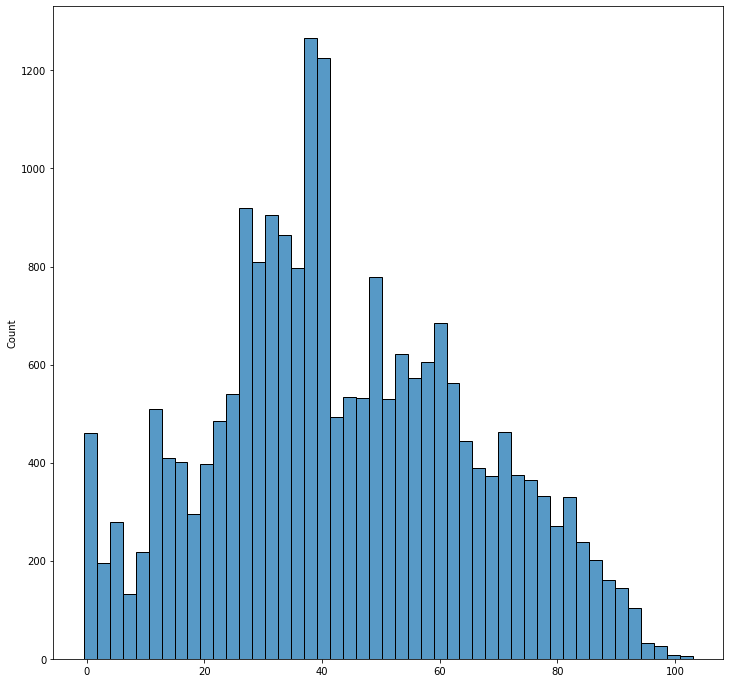

In [25]:
fig, ax = plt.subplots(figsize=(12,12))

sns.histplot(ages, kde=False, ax=ax)

plt.show()

### Download IDAT Files for all samples 

In [26]:
idat_directory = f'{wd}idat_files/'
temp_dir = f'{wd}temp/'

In [27]:
for exp, exp_meta in idat_exps.items():
    good = False
    for file in exp_meta['suppl'][1]:
        if 'RAW' in file:
            good = True
    if not good:
        print(exp, exp_meta['suppl'])

In [28]:
def get_raw_file(exp_meta):
    for file in exp_meta['suppl'][1]:
        if 'RAW' in file:
            return file
    return None

In [29]:
def download_and_extract_idats(exp, temp_head, output_directory):
    suppl_head, files = exp.get('suppl', (None, None))
    suppl_file = get_raw_file(exp)
    if not suppl_file:
        return exp['accession_id']
    else:
        suppl_path = f'{exp["ftp_head"]}/{suppl_head}/{suppl_file}'
        temp_directory = f'{temp_head}{exp["accession_id"]}/'
        try:
            os.mkdir(temp_directory)
        except FileExistsError:
            return exp['accession_id']
        wget_command = ['wget', '-nd', '-P', 
                        temp_directory, suppl_path]
        subprocess.Popen(['mkdir', '-p', ])
        p_1 = subprocess.Popen(args=wget_command)
        p_1.wait()
        p_2 = subprocess.Popen(['tar', '-C', temp_directory, '-xvf', f'{temp_directory}{suppl_file}'])
        p_2.wait()
        for head, directory, files in os.walk(temp_directory):
            for file in files:
                if 'idat' in file.lower():
                    shutil.move(f'{head}/{file}', f'{output_directory}{file}')
                else:
                    os.remove(f'{head}/{file}')
        os.rmdir(temp_directory)
        if p_1.returncode or p_2.returncode:
            return exp['accession_id']
        else:
            return 0

```python
download_status = joblib.Parallel(n_jobs=32, verbose=10)(joblib.delayed(download_and_extract_idats)
                                                         (*[idat_exps[exp], temp_dir, idat_directory]) for exp in idat_exps)
```

## Check idat sample info

In [30]:
def check_idat_files(gsm_meta, idat_directory):
    idat_files = [os.path.exists(f'{idat_directory}{gsm_meta["Grn"]}'),
                  os.path.exists(f'{idat_directory}{gsm_meta["Red"]}')]
    if not all(idat_files):
        return 1
    return 0

In [31]:
all_sample_meta = {gsm_id: gsm_meta for gsm_id, gsm_meta 
                   in idat_sample_meta.items() if not check_idat_files(gsm_meta, idat_directory)}

### Process IDAT Files
- all samples are 450k 
- process as expermental groups with reference samples attached

In [32]:
process_exps = set([sample['experiment_id'] for sample in all_sample_meta.values()])

In [33]:
def batch_samples(samples: List[str], batch_size: int = 100) -> List[List[str]]:
        """Generate sample batches"""
        batches = []
        batch_size = int(batch_size)
        batch_number = int(len(samples) / batch_size)
        if not batch_number:
            batch_number = 1
        batch_remainder = len(samples) % batch_size
        if float(batch_remainder) / batch_size <= .6 and batch_remainder != 0:
            batch_addition = int(batch_remainder / batch_number)
            batch_size += batch_addition + 1
            print(f'Adjusting batch size, new batch size = {batch_size}')
        start, end = 0, batch_size
        while True:
            batch = samples[start: end]
            if not batch:
                break
            batches.append(batch)
            start += batch_size
            end += batch_size
        return batches

In [34]:
100 / 12

8.333333333333334

In [36]:
processing_batches = {}

for exp in process_exps:
    exp_samples = []
    for gsm_info in all_sample_meta.values():
        if gsm_info['experiment_id'] == exp:
            exp_samples.append(gsm_info['Red'].replace('_Red.idat.gz', ''))
    chip_ids = Counter([sample.split('_')[1] for sample in exp_samples])
    chip_size = math.ceil(np.mean(list(chip_ids.values())))
    chip_ids = list(chip_ids.keys())
    batch_size = 16 if abs(chip_size - 8) <= 1 else 12
    exp_batches = batch_samples(chip_ids, batch_size)
    initial_batches = []
    for count, batch in enumerate(exp_batches):
        batch_exp_samples = []
        for sample in exp_samples:
            if sample.split('_')[1] in batch:
                batch_exp_samples.append(sample)
        initial_batches.append(batch_exp_samples)
        processing_batches[f'{exp}_{count + 1}'] = batch_exp_samples

Adjusting batch size, new batch size = 15
Adjusting batch size, new batch size = 19
Adjusting batch size, new batch size = 21
Adjusting batch size, new batch size = 13
Adjusting batch size, new batch size = 13
Adjusting batch size, new batch size = 17
Adjusting batch size, new batch size = 16
Adjusting batch size, new batch size = 13
Adjusting batch size, new batch size = 25
Adjusting batch size, new batch size = 17
Adjusting batch size, new batch size = 13
Adjusting batch size, new batch size = 17
Adjusting batch size, new batch size = 20
Adjusting batch size, new batch size = 19
Adjusting batch size, new batch size = 21
Adjusting batch size, new batch size = 16
Adjusting batch size, new batch size = 19
Adjusting batch size, new batch size = 18
Adjusting batch size, new batch size = 14
Adjusting batch size, new batch size = 16
Adjusting batch size, new batch size = 17
Adjusting batch size, new batch size = 25
Adjusting batch size, new batch size = 26
Adjusting batch size, new batch si

```python
for batch, samples in processing_batches.items():
    with open(f'ProcessExpsRefs/{batch}.txt', 'w') as out:
        out.write('\n'.join(samples))
        
with open(f'ref_sheets.txt', 'w') as out:
    out.write('\n'.join(list(processing_batches.keys()) + ['']))
```

In [37]:
cleaned_processing_batches = {}

for exp in processing_batches:
    with open(f'ProcessExpsRefs/{exp}.txt', 'r') as batch:
        batch_samples = []
        for sample in batch:
            batch_samples.append(sample.strip())
        cleaned_processing_batches[exp] = batch_samples
        
processing_batches = cleaned_processing_batches

In [38]:
batch_order = []

with open('ref_sheets.txt', 'r') as ref:
    for line in ref:
        batch_order.append(line.strip())

In [39]:
processing_batches = {batch: processing_batches[batch] for batch in batch_order}

### Parse Processed Data and Update Sample Metadata

In [40]:
processed_dir = f'{wd}processed_data/'

In [41]:
def open_gzip(file_path: str, yield_indices: Union[List[int], None] = None):
    with io.BufferedReader(gzip.open(file_path, 'rb')) as file:
        for line in file:
            d_line = line.decode('utf-8').strip()
            y_line = d_line.replace('"', '').split(',')
            if not yield_indices:
                yield y_line
            else:
                yield [y_line[index] for index in yield_indices]

In [42]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value

In [43]:
def get_meta_data(file_path) -> dict:
    header = None
    meta_data = {}
    for line in open_gzip(file_path):
        if not header:
            header = line[1:]
        else:
            sample = line[0].split('_')[0]
            meta_data[sample] = {f'proc_{key}':convert_to_float(value) for key, value in zip(header, line[1:])}
    return meta_data

In [44]:
unprocessed_batches = [batch for batch in processing_batches if not os.path.exists(f'{processed_dir}{batch}_qc.gz')]
unprocessed_exps = set([batch.split('_')[0] for batch in unprocessed_batches])

In [45]:
# check to see whole experiments throwing errors and not just individual batches

for count, batch in enumerate(processing_batches):
    if batch.split('_')[0] in unprocessed_exps:
        print(batch, count + 1, batch in unprocessed_batches, idat_exps[batch.split('_')[0]]['platform_id'])

GSE144910_1 27 True GPL21145
GSE144910_2 28 True GPL21145
GSE144910_3 29 True GPL21145
GSE144910_4 30 True GPL21145
GSE144910_5 31 True GPL21145
GSE144910_6 32 True GPL21145
GSE144910_7 33 True GPL21145
GSE117130_1 117 True GPL21145
GSE117130_2 118 True GPL21145
GSE136296_1 128 True GPL21145


In [46]:
all_sample_meta = {sample:sample_info for sample, sample_info in all_sample_meta.items() if sample_info['experiment_id'] not in unprocessed_exps}

In [47]:
ref_sample_meta = []

for exp in tqdm(processing_batches):
    if exp in unprocessed_batches:
        continue
    exp_id, batch = exp.split('_')
    qc_meta = get_meta_data(f'{processed_dir}{exp}_qc.gz')
    cell_meta = get_meta_data(f'{processed_dir}{exp}_cell_counts.gz')
    for sample in qc_meta:
        sample_qc = qc_meta[sample]
        proc_qc_fail = 0
        if sample_qc['proc_mMed'] < 10.0 or sample_qc['proc_mMed'] < 10.0:
            proc_qc_fail = 1
        all_sample_meta[sample]['proc_qc_fail'] = proc_qc_fail
        all_sample_meta[sample]['batch'] = batch
        all_sample_meta[sample].update(sample_qc)
        all_sample_meta[sample].update(cell_meta[sample])
        all_sample_meta[sample]['processing_complete'] = 1

In [48]:
sample_meta = {sample:sample_info for sample, sample_info in all_sample_meta.items() if 'processing_complete' in sample_info}

In [49]:
if not os.path.exists(f'{wd}processed_sample_meta.pkl'):
    with open(f'{wd}processed_sample_meta.pkl', 'wb') as out:
        pickle.dump(sample_meta, out)
    with open(f'{wd}processed_ref_meta.pkl', 'wb') as out:
        pickle.dump(ref_sample_meta, out)